In [25]:
import matplotlib.pyplot as plt
import urllib.request, json
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Embedding, Dense, SimpleRNN
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [26]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
plt.rcParams['figure.figsize'] = (5, 5)
plt.rc('font', size=5)

Num GPUs Available:  0


In [27]:
res = urllib.request.urlopen("http://127.0.0.1:8000/api/vagas?treinamento=true")
data = json.loads(res.read())
exemplos_treinamento = data['data']
qtd_pos = data['qtd_pos']
qtd_neg = data['qtd_neg']

In [33]:
sentences = []
pos = []
maxlen = 46

def converteTextoParaTokens(texto : str):
    tokens = list(map(lambda x: str(x).lower(), tokenizer.tokenize(texto)))
    for i in range(len(tokens)):
        if tokens[i].isdigit():
            tokens[i] = "num"
    return tokens

for exemplo in exemplos_treinamento:
    tokens = converteTextoParaTokens(exemplo['txtVaga'])
    aplicacao = exemplo['isApplied']
    sentences.append(tokens)
    pos.append([int(bool(aplicacao))])
    
    if len(tokens) > maxlen:
        maxlen = len(tokens)
        print("Maxlen atualizado: ",  maxlen)

In [34]:
word_list = ['<pad>'] + sorted(set(sum(sentences, []))) + ['_UNKNOWN']
word2idx = {word:idx for idx, word in enumerate(word_list)}
idx2word = {idx:word for idx, word in enumerate(word_list)}
pos_list = sorted(set(sum(pos, [])))
pos2idx = {pos:idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx:pos for idx, pos in enumerate(pos_list)}
X = list(map(lambda sentence: [word2idx.get(token) for token in sentence], sentences))
y = list(map(lambda sentence: [pos2idx.get(token) for token in sentence], pos))
X = pad_sequences(X, maxlen=maxlen, padding='post')
X_mask = (X != 0).astype(np.float32)
X_len = np.array(list((map(lambda sentence: len(sentence), sentences))), dtype=np.float32)
y = pad_sequences(y, maxlen=1, padding='post')

json_str = json.dumps(word2idx, ensure_ascii=False)
json_str = json.loads(json_str)
with open('char2idx.json', 'w', encoding='utf-8') as json_file:
    json.dump(json_str, json_file, ensure_ascii=False)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 696ms/step - accuracy: 0.9001 - auc: 0.6107 - fn: 61.8649 - fp: 1936.0541 - loss: 0.4531 - prc: 0.0438 - precision: 0.0322 - recall: 0.5248
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 670ms/step - accuracy: 0.8978 - auc: 0.7832 - fn: 29.8108 - fp: 1742.7838 - loss: 0.3928 - prc: 0.0832 - precision: 0.0465 - recall: 0.7888
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 746ms/step - accuracy: 0.9078 - auc: 0.8479 - fn: 36.4054 - fp: 1105.5405 - loss: 0.4042 - prc: 0.1134 - precision: 0.0808 - recall: 0.7256
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 625ms/step - accuracy: 0.9089 - auc: 0.9018 - fn: 23.9730 - fp: 863.1622 - loss: 0.3512 - prc: 0.1527 - precision: 0.1040 - recall: 0.8313
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 617ms/step - accuracy: 0.8838 - auc: 0.9078 - fn: 17.4324 - fp: 942.2703 - loss: 0.3188 - prc: 0.1379 - precision: 0.0963 - recall: 0.8790
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 635ms/step - accuracy: 0.8834 - auc: 0.9220 - fn: 

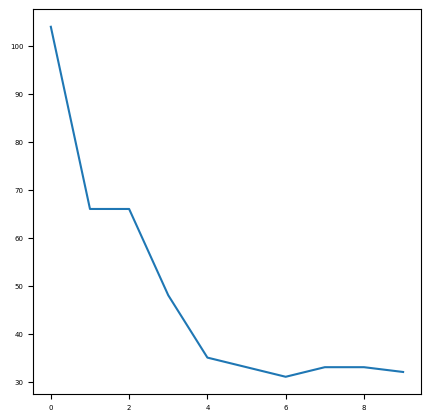

In [35]:

num_classes = len(pos2idx)
input_dim = len(word2idx)
output_dim = len(word2idx)
exemples_dim = len(sentences)
batch_size = 300
epochs = 10

optimizer = Adam()

loss_function = BinaryCrossentropy()
additional_metrics = [
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.6),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')
]

model = Sequential()
model.add(Embedding(
    input_dim=input_dim,
    output_dim=output_dim,
    mask_zero=True,
    embeddings_initializer=tf.keras.initializers.random_normal
))
model.add(SimpleRNN(units=3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
#model.summary()

weight_for_0 = (1 / qtd_neg) * (exemples_dim / 3.0)
weight_for_1 = (1 / qtd_pos) * (exemples_dim / 3.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

history = model.fit(X, y, class_weight=class_weight, batch_size=batch_size, shuffle=True, epochs=epochs, verbose=True)

plt.figure()
plt.plot(history.history['fn'])
plt.show()

In [ ]:
# Exemplo de inferência
novo_X = [['desenvolvedor', 'web', 'java','junior']]
novo_X = list(map(lambda sentence: [word2idx.get(token) for token in sentence], novo_X))
novo_X = pad_sequences(novo_X, maxlen=maxlen, padding='post')
y_pred = model.predict(novo_X, batch_size=1)[0]
y_pred

In [36]:
model.save("model.keras")